# Bare soil sampling with Google Earth Engine

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import pickle
from typing import List
from shapely.geometry import Polygon, MultiPolygon
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import contextily as cx
import shapely.geometry as sg
import os
from pathlib import Path
import glob
base_dir = Path(os.path.dirname(os.path.realpath("__file__"))).parent.parent

### Create shp for querying with GEE

In [2]:
tiles = {'32TMT': [(7.66286529045287, 47.845914826827),(7.68758850048273, 46.8581759574933),(9.12805716115049, 46.8656282472998),(9.1304703619161, 47.8536277114283),(7.66286529045287, 47.845914826827)],
            '32TLT': [(6.32792675947954,47.8225951267953),(6.37728036218156, 46.8356437136561),(7.81664846692137, 46.8595830833696),(7.79435498889756, 47.8473711518664),(6.32792675947954, 47.8225951267953)],
            '32TNT': [(8.9997326423426, 47.8537018420053),(8.99973758744939,46.8656998728757),(10.4401498244026, 46.8566398814282),(10.4672773767603, 47.8443250460311),(8.9997326423426, 47.8537018420053)],
            '32TNS': [(8.99973715756222,46.9537091787344),(8.9997418700468, 45.9655511480415),(10.4166561015996, 45.9567698586004),(10.442508097938, 46.9446214409232),(8.99973715756222, 46.9537091787344)],
            '32TMS': [(7.68543924709582, 46.9461622205863),(7.7089998702566, 45.9582586884214),(9.12596726307512, 45.9654817261501),(9.12826694512377, 46.9536373337673),(7.68543924709582, 46.9461622205863)],
            '32TLS': [(6.37298980762373, 46.9235610080068),(6.42002507864337, 45.9364192287437),(7.83595551698163, 45.9596225320207),(7.81471043979331, 46.94757365544),(6.37298980762373, 46.9235610080068)],
            '31TGM': [(5.62648535526562, 46.9235730577955),(5.57945945554239, 45.9364308725672),(6.99300216652316, 45.8957352511058),(7.06565713267192, 46.8814596607493),(5.62648535526562, 46.9235730577955)],
            '31TGN': [(5.67153942638492, 47.8226075594756),(5.62219565549863, 46.8356557266896),(7.05902986502132, 46.793670687313),(7.13525847525188, 47.7791570713891),(5.67153942638492, 47.8226075594756)]}

In [ ]:
geowp_path = '/home/f80873755@agsad.admin.ch/mnt/Data-Work-RE/27_Natural_Resources-RE/99_GIS_User_protected/GeoWP/Landuse/Landw_Kulturflaechen/2021/01_Geodata/SHP/Nutzungsflaechen_BLW_Schweizweit_merge/ln_nutzung_BLW_2021_CH.shp'
geowp = gpd.read_file(geowp_path).to_crs(4326)
    
for tile_id, tile_coords in tiles.items():
    print(f'Creating shp for tile {tile_id}...')

    tile = Polygon(tile_coords)
    tile_gdf = gpd.GeoDataFrame(geometry=[tile], crs='EPSG:4326')

    # Divide each tile into 4 smaller tiles
    subdivide_factor = 2  # You can adjust this based on requirement
    subdivided_tiles = []
    for i in range(subdivide_factor):
        for j in range(subdivide_factor):
            min_x, min_y, max_x, max_y = tile_gdf.total_bounds
            sub_tile = sg.box(
                min_x + i * (max_x - min_x) / subdivide_factor,
                min_y + j * (max_y - min_y) / subdivide_factor,
                min_x + (i + 1) * (max_x - min_x) / subdivide_factor,
                min_y + (j + 1) * (max_y - min_y) / subdivide_factor
            )
            subdivided_tiles.append(sub_tile)

    # Save each subdivided tile
    for idx, sub_tile in enumerate(subdivided_tiles):
        print(sub_tile)
        # Take extra surrounding fields using GeoWP
        geowp_cropped = geowp.to_crs(4326).cx[sub_tile.bounds[0]:sub_tile.bounds[2], sub_tile.bounds[1]:sub_tile.bounds[3]]
        geowp_with_buffer = geowp_cropped.copy()
        buffer_distance = -60  # in meters, if the crs of the gdf is metric
        geowp_with_buffer['geometry'] = geowp_cropped.to_crs(2056).buffer(buffer_distance)
        sub_tile_gdf = gpd.GeoDataFrame(geometry=[sub_tile], crs='EPSG:4326')
        geom = gpd.overlay(sub_tile_gdf.to_crs(geowp_with_buffer.crs), geowp_with_buffer, how='intersection') # is in epsg 2056
        if len(geom):
            geom.to_crs(4326).to_file(base_dir.joinpath(f'data/tile_geowp/{tile_id}_geowp_part_{idx+1}.shp'))

In [5]:
# Further divide a subtile

geowp_path = '/home/f80873755@agsad.admin.ch/mnt/Data-Work-RE/27_Natural_Resources-RE/99_GIS_User_protected/GeoWP/Landuse/Landw_Kulturflaechen/2021/01_Geodata/SHP/Nutzungsflaechen_BLW_Schweizweit_merge/ln_nutzung_BLW_2021_CH.shp'
geowp = gpd.read_file(geowp_path).to_crs(4326)

tile_id = '31TGM'
sub_tile_part = 4
    
tile_coords = tiles[tile_id]
tile = Polygon(tile_coords)
tile_gdf = gpd.GeoDataFrame(geometry=[tile], crs='EPSG:4326')

# Divide each tile into 4 smaller tiles
subdivide_factor = 2  # You can adjust this based on requirement
subdivided_tiles = []
for i in range(subdivide_factor):
    for j in range(subdivide_factor):
        min_x, min_y, max_x, max_y = tile_gdf.total_bounds
        sub_tile = sg.box(
            min_x + i * (max_x - min_x) / subdivide_factor,
            min_y + j * (max_y - min_y) / subdivide_factor,
            min_x + (i + 1) * (max_x - min_x) / subdivide_factor,
            min_y + (j + 1) * (max_y - min_y) / subdivide_factor
        )
        subdivided_tiles.append(sub_tile)

# Save each subdivided tile
for idx, sub_tile in enumerate(subdivided_tiles):
    # Take extra surrounding fields using GeoWP
    geowp_cropped = geowp.to_crs(4326).cx[sub_tile.bounds[0]:sub_tile.bounds[2], sub_tile.bounds[1]:sub_tile.bounds[3]]
    geowp_with_buffer = geowp_cropped.copy()
    buffer_distance = -60  # in meters, if the crs of the gdf is metric
    geowp_with_buffer['geometry'] = geowp_cropped.to_crs(2056).buffer(buffer_distance)
    sub_tile_gdf = gpd.GeoDataFrame(geometry=[sub_tile], crs='EPSG:4326')
    geom = gpd.overlay(sub_tile_gdf.to_crs(geowp_with_buffer.crs), geowp_with_buffer, how='intersection') # is in epsg 2056
    if len(geom):
        geom.to_crs(4326).to_file(base_dir.joinpath(f'data/tile_geowp/{tile_id}_geowp_part_{sub_tile_part}{idx+1}.shp'))

### View geom and subtiles

In [6]:
# Open single subtile

tile_geowp = base_dir.joinpath('data/tile_geowp/32TNT_geowp_part_4.shp')
tile_geowp = gpd.read_file(tile_geowp)
print(len(tile_geowp))

0


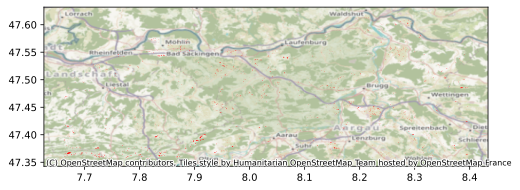

In [6]:
# Plot single subtile

tile_geowp = base_dir.joinpath('data/tile_geowp/32TMT_geowp_part_2.shp')
tile_geowp = gpd.read_file(tile_geowp)

fig, ax = plt.subplots(figsize=(8,6))
tile_geowp.plot(ax=ax, color='r')
cx.add_basemap(ax, crs=tile_geowp.crs)

In [7]:
# Plot geom in subtiles

for row, (tile_id, _) in enumerate(tiles.items()):
    subtile_paths = glob.glob(str(base_dir.joinpath(f'data/tile_geowp/{tile_id}_geowp_part_*.shp')))
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 6))
    for col, sub_tile in enumerate(subtile_paths):  # Assuming you want only the first 4 subtiles
        sub_tile_gdf = gpd.read_file(sub_tile)
        print(sub_tile, len(sub_tile_gdf))
        ax = axes[col] #axes[row, col]
        sub_tile_gdf.plot(ax=ax)
        ax.set_title(f'{tile_id} - {sub_tile.split("_")[-1].split(".")[0]}')
        cx.add_basemap(ax, crs=sub_tile_gdf.crs)

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()

/mnt/eo-nas1/eoa-share/projects/010_CropCovEO/data/tile_geowp/32TMT_geowp_part_1.shp 8755
/mnt/eo-nas1/eoa-share/projects/010_CropCovEO/data/tile_geowp/32TMT_geowp_part_2.shp 2712
/mnt/eo-nas1/eoa-share/projects/010_CropCovEO/data/tile_geowp/32TMT_geowp_part_3.shp 5491
/mnt/eo-nas1/eoa-share/projects/010_CropCovEO/data/tile_geowp/32TMT_geowp_part_4.shp 6489
/mnt/eo-nas1/eoa-share/projects/010_CropCovEO/data/tile_geowp/32TLT_geowp_part_1.shp 5848
/mnt/eo-nas1/eoa-share/projects/010_CropCovEO/data/tile_geowp/32TLT_geowp_part_2.shp 759
/mnt/eo-nas1/eoa-share/projects/010_CropCovEO/data/tile_geowp/32TLT_geowp_part_3.shp 10465
/mnt/eo-nas1/eoa-share/projects/010_CropCovEO/data/tile_geowp/32TLT_geowp_part_4.shp 2863
/mnt/eo-nas1/eoa-share/projects/010_CropCovEO/data/tile_geowp/32TNT_geowp_part_1.shp 2775
/mnt/eo-nas1/eoa-share/projects/010_CropCovEO/data/tile_geowp/32TNT_geowp_part_2.shp 4945
/mnt/eo-nas1/eoa-share/projects/010_CropCovEO/data/tile_geowp/32TNT_geowp_part_3.shp 74
/mnt/eo-nas1

ValueError: aspect must be finite and positive 

In [8]:
# Plot subtile bounds

#fig, axes = plt.subplots(nrows=len(tiles), ncols=4, figsize=(15, len(tiles) * 4))

for row, (tile_id, tile_coords) in enumerate(tiles.items()):
    
    tile = Polygon(tile_coords)
    tile_gdf = gpd.GeoDataFrame(geometry=[tile], crs='EPSG:4326')

    # Divide each tile into 4 smaller tiles
    subdivide_factor = 2  # You can adjust this based on requirement
    subdivided_tiles = []
    for i in range(subdivide_factor):
        for j in range(subdivide_factor):
            min_x, min_y, max_x, max_y = tile_gdf.total_bounds
            sub_tile = sg.box(
                min_x + i * (max_x - min_x) / subdivide_factor,
                min_y + j * (max_y - min_y) / subdivide_factor,
                min_x + (i + 1) * (max_x - min_x) / subdivide_factor,
                min_y + (j + 1) * (max_y - min_y) / subdivide_factor
            )
            subdivided_tiles.append(sub_tile)


    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 6))
    for idx, sub_tile in enumerate(subdivided_tiles):
        sub_tile_gdf = gpd.GeoDataFrame(geometry=[sub_tile], crs='EPSG:4326')

        ax = axes[idx]
        sub_tile_gdf.plot(ax=ax)
        ax.set_title(f'{tile_id} - part {idx+1}')
        bounds = tile_gdf.total_bounds
        ax.set_xlim(bounds[0], bounds[2])
        ax.set_ylim(bounds[1], bounds[3])
        cx.add_basemap(ax, crs=sub_tile_gdf.crs)

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()

[ 7.66286529 46.85817596  9.13047036 47.85362771]
[ 7.66286529 46.85817596  9.13047036 47.85362771]
[ 7.66286529 46.85817596  9.13047036 47.85362771]
[ 7.66286529 46.85817596  9.13047036 47.85362771]


### Load rasters generated on GEE

In [18]:
import geopandas as gpd
import rasterio
from shapely.geometry import Point
import numpy as np


def load_raster_gdf(tif_path: Path):
    """Load raster data into a GeoDataFrame.
    
    :param tif_path: Path to the GeoTIFF raster file
    """

    # Read the raster data using rasterio
    with rasterio.open(tif_path) as src:
        # Read raster data as a NumPy array
        raster_array = src.read()  # Read all bands

        # Get the metadata for coordinate reference system (CRS) and transform
        crs = src.crs.to_string()

    # Create a grid of points representing each pixel
    rows, cols = raster_array.shape[1:]
    x_coords, y_coords = np.meshgrid(np.linspace(src.bounds.left, src.bounds.right, cols),
                                    np.linspace(src.bounds.top, src.bounds.bottom, rows))

    # Flatten the coordinates
    flat_x_coords = x_coords.flatten()
    flat_y_coords = y_coords.flatten()

    # Create a GeoDataFrame with points
    geometry = [Point(x, y) for x, y in zip(flat_x_coords, flat_y_coords)]
    gdf = gpd.GeoDataFrame(geometry=geometry, crs=crs)

    # Add columns for each band value
    col_names = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12', 'ndvi', 'nbr2']
    for i, band_values in enumerate(raster_array):
        gdf[f'{col_names[i]}'] = band_values.flatten()

    gdf.dropna(inplace=True)

    return gdf


# Specify the path to your GeoTIFF raster file
tif_path = base_dir.joinpath('data/S2_BS/S2_BS_2017_Strickhof.tif')
gdf = load_raster_gdf(tif_path)
gdf.head()

,geometry,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,ndvi,nbr2
3621,POINT (2694156.932 1256217.661),885.0,1229.0,1521.0,1861.0,2138.0,2248.0,2428.0,2313.0,3647.0,2774.0,2463.0,0.229678,0.059385
3794,POINT (2694106.364 1256197.544),614.0,931.0,1130.0,1344.0,1513.0,1616.0,1709.0,1762.0,2179.0,2201.0,1959.0,0.203945,0.058173
3795,POINT (2694116.477 1256197.544),634.0,950.0,1165.0,1344.0,1513.0,1616.0,1614.0,1762.0,2179.0,2201.0,1959.0,0.161569,0.058173
3798,POINT (2694146.818 1256197.544),748.0,1047.0,1324.0,1388.0,1629.0,1671.0,1800.0,1668.0,2827.0,2223.0,1974.0,0.152369,0.059328
3799,POINT (2694156.932 1256197.544),526.0,1423.0,1765.0,1982.0,2092.0,2035.0,2424.0,2367.0,3647.0,2868.0,2621.0,0.157317,0.044999
